<a href="https://colab.research.google.com/github/pbonillor/IA_GENERATIVA_CON_PYTHON/blob/main/MODULO_III/RAG_web_charla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

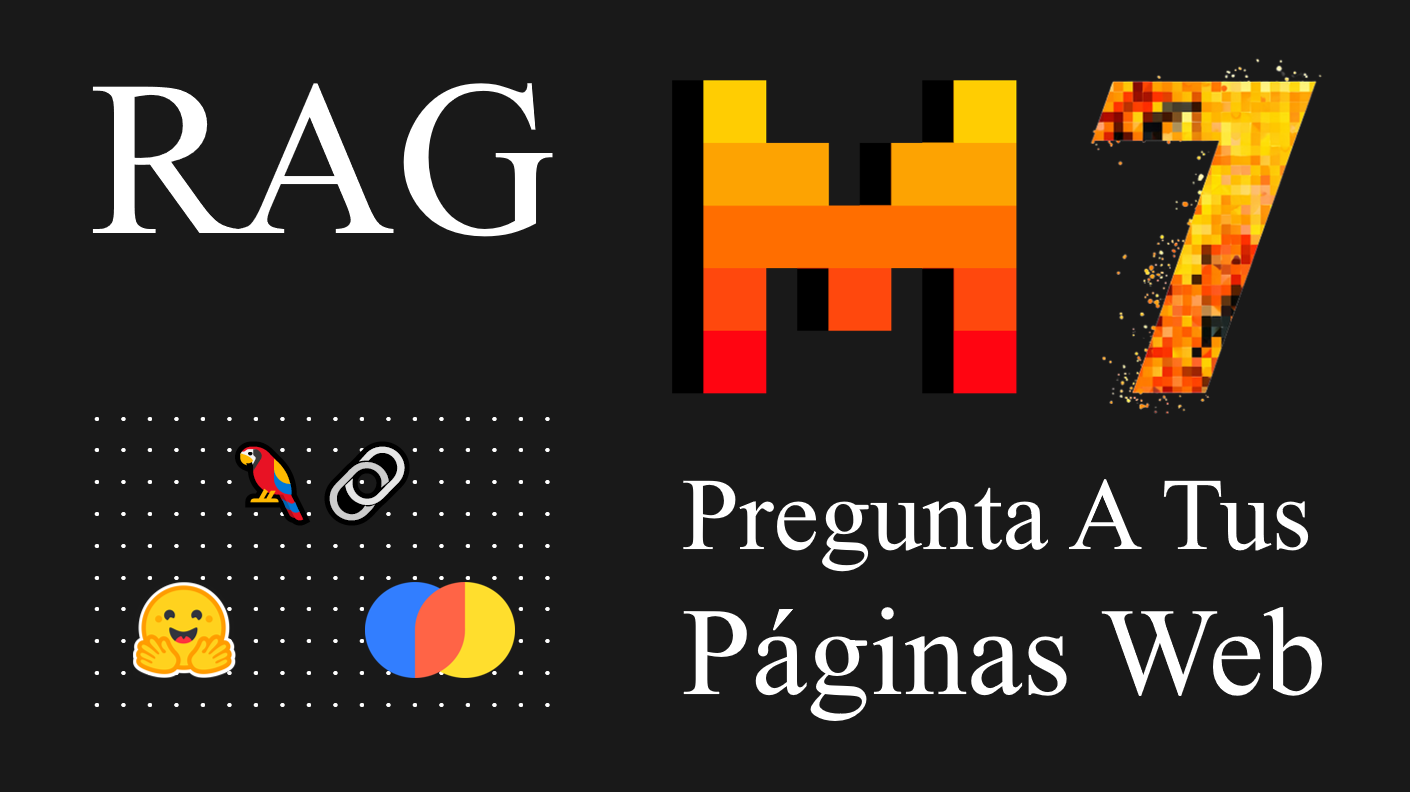

### **Introducción**

¿Cómo se puede aumentar el conocimiento de los LLM con datos con los que no han sido entrenados? La **Generación Aumentada de Recuperación (RAG)** es el camino a seguir. En este blog explicaremos qué significa RAG y por supuesto, cómo funciona.

Digamos que tienes tu propio conjunto de datos, por ejemplo, documentos de texto de tu empresa. ¿Cómo puedes hacer que **ChatGPT** y otros LLM los conozcan y respondan a tus preguntas?

Aqui la respuesta: no te preocupes, se puede hacer fácilmente en los siguientes cuatro pasos:

1. **Embedding:**
Incrusta tus documentos con un modelo de incrustación como **text-embedding-ada-002** de OpenAI o **S-BERT**. Incrustar un documento significa transformar sus frases, palabras o trozos de las palabras en un vector de números. La idea es que las frases que son similares entre sí deben estar cerca en términos de distancia entre sus vectores y las frases que son diferentes deben estar más lejos.

2. **Vector Store:**
Una vez que tienes una lista de números, puedes **almacenarlos** en un **almacén vectorial** como **ChromaDB**, **FAISS**, o **Pinecone**. Un almacén vectorial es como una base de datos pero, como su nombre indica, **indexa** y **almacena** incrustaciones vectoriales para su **rápida recuperación** y la **búsqueda de similitudes**.

3. **Consulta**
Ahora que tu documento está incrustado y almacenado, cuando hagas una pregunta específica a un LLM, éste incrustará tu consulta y encontrará en el almacén de vectores las frases que más se acerquen a tu pregunta en términos de **semejanza de coseno**, por ejemplo.

4. **Responder a tu pregunta:**
Una vez encontradas las frases más parecidas, se suman en la consulta y ¡listo! Ahora, los LLM son capaces de responder a preguntas concretas sobre datos con los que no han sido entrenados, **sin necesidad de reentrenamiento** o **fine-tuning**. ¿No es genial?

### **Pushing Boundries**

En mi última entrada de blog titulada **Ask Your Own Data Using LangChain & LlamaIndex**, aumentamos el conocimiento de **ChatGPT**, desplegado en **Azure**, utilizando **datos privados** para hacerlo más factual. En otras palabras, implementamos una aplicación **RAG** en la que se emplearon dos modelos comerciales de Azure OpenAI,en nuestro caso, el modelo **ada-embeddings-001** para embeddings y **GPT-3.5 Turbo**, que genera respuestas basadas en preguntas o consultas del usuario y contexto relevante. Este contexto relevante consiste en documentos recuperados a partir de un paso de búsqueda mediante búsqueda semántica.

Una desafortunada realidad es que este servicio no es gratuito. En otras palabras, se cobra por cada token generado por el modelo, que es esencialmente uno de los inconvenientes de los modelos comerciales y de código cerrado. Lo ideal sería que la IA fuera de código abierto y se democratizara, como ha señalado por **Clem Delangue**, CEO de Hugging Face: **Es increíblemente difícil empezar sin modelos y conjuntos de datos abiertos**.

### **Empezamos**

Pero calma, aún no lo hemos dicho todo; ¡abrochaos los cinturones!. Ahora nos embarcaremos en un viaje de codificación de alta velocidad para demostrar cómo puedes construir un sistema RAG** completamente **libre** utilizando modelos **de código abierto** alojados en el **Hugging Face** Model Hub y codificar cada componente en su siguiente arquitectura:

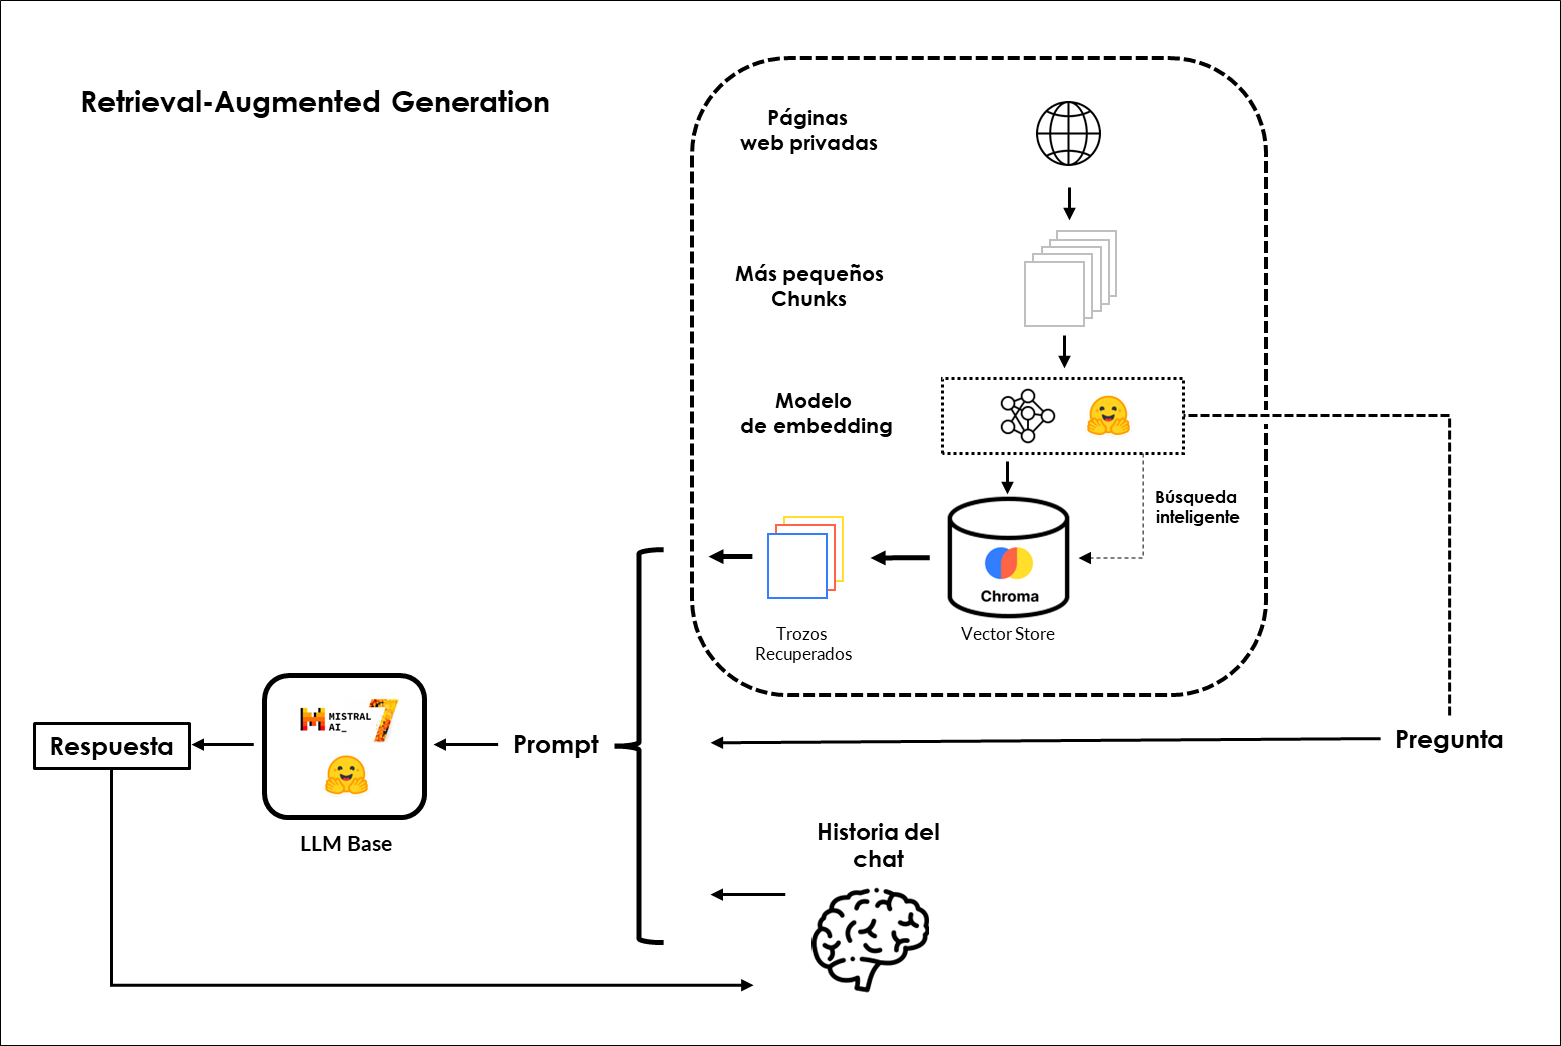

#### Instalaciones

Estas líneas de código están instalando varias **librerías Python** y **paquetes** usando el gestor de paquetes **pip**, jutno con la bandera **--quiet** la cual se usa para reducir la cantidad de salida mostrada durante el proceso de instalación, haciéndolo menos ruidoso.

In [1]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet

#### Importaciones

En el siguiente script, importamos una amplia gama de **bibliotecas** y **módulos** para tareas avanzadas de procesamiento del lenguaje natural y generación de texto. Esencialmente, estamos configurando un entorno para trabajar con modelos de lenguaje, incluyendo modelos **Hugging Face**, así como diversas herramientas y utilidades para el manejo y procesamiento de datos de texto

Importamos principalmente **PyTorch** para capacidades de aprendizaje profundo y **Gradio** para construir interfaces interactivas de modelos ML. Además, importamos módulos de la biblioteca **langchain**, que incluye plantillas para crear prompts, varios modelos de cadena para la comprensión y generación de lenguaje, text embeddings y cargadores de documentos. Nuestro código también integra la potente biblioteca **Transformers**, que permite el uso sin problemas de **los modelos de última generación de Hugging Face** para una amplia gama de aplicaciones de PLN.

In [2]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

#### LLM Base

**Mistral-7b** desarrollado por **Mistral AI** está arrasando en el panorama de los LLM de código abierto. Este nuevo LLM de código abierto supera a LLaMA-2 en muchas pruebas comparativas, como ilustra la siguiente imagen extraída de su documento:

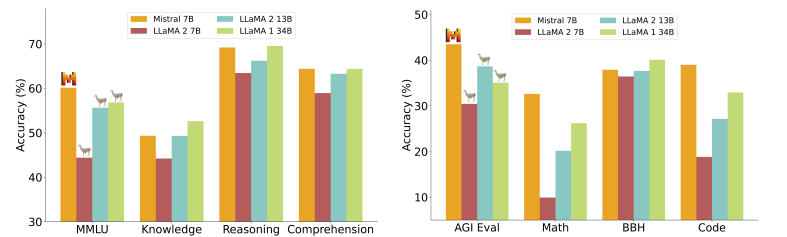

El siguiente fragmento de código se configura un **proceso de generación de texto** utilizando un LLM base, **Mistral-7b** desarrollado por **Mistral AI**, instruye al modelo de lenguaje preentrenado, lo configura con ajustes de **cuantización**, **tokenización** y **parámetros de generación**, y crea un proceso que puede utilizarse para generar texto basado en el LLM **Mistral-7b** y las configuraciones. Vamos a desglosar lo que sucede:

* **`quantization_config = BitsAndBytesConfig(...)`**: Aquí se define una configuración de **cuantización** utilizando **BitsAndBytesConfig**. La cuantificación es una técnica utilizada para reducir los requisitos de memoria y computación de los modelos de aprendizaje profundo, normalmente mediante el uso de **menos bits**, **4 bits** en nuestro caso para representar los parámetros del modelo.

* **`tokenizer = AutoTokenizer.from_pretrained(...)`**: Esta línea inicializa un tokenizador para el modelo **Mistral-7b**, permitiéndole preprocesar datos de texto para introducirlos en el modelo.

* **`model = AutoModelForCausalLM.from_pretrained(...)`**: Esto inicializa el modelo de lenguaje **Mistral-7b** pre-entrenado para el modelado causal del lenguaje. El modelo se configura con varios parámetros, incluyendo la **configuración** de **cuantización**, que se estableció anteriormente.

* **`generation_config = GenerationConfig.from_pretrained(...)`**: Se crea una **configuración de generación** para el modelo, especificando varios parámetros relacionados con la generación, como el **número máximo de tokens**, la **temperature** para el **sampling**, el **top-p sampling** y la **repetition penalty**.

* **`pipeline = pipeline(...)`**: Por último, se crea una línea de generación de texto utilizando la función **pipeline**. Esta tubería se configura para la generación de texto, y toma el modelo pre-entrenado, el tokenizer, y la configuración de generación como entradas. Está configurado para devolver salidas de texto completo.


In [3]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024
generation_config.temperature = 0.0001
generation_config.top_p = 0.95
generation_config.do_sample = True
generation_config.repetition_penalty = 1.15

pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**HuggingFacePipeline** es una clase que permite ejecutar modelos Hugging Face localmente. Se utiliza para acceder y utilizar una amplia gama de modelos ML pre-entrenados alojados en el Hugging Face Model Hub. En nuestro caso, la utilizaremos dentro de nuestro entorno LangChain para interactuar con los modelos de Hugging Face como **local wrapper**. Sin embargo, cuando se trabaja con HuggingFacePipeline, se recomienda la instalación de **xformer** para una implementación de atención más eficiente en memoria. Por eso lo hemos instalado más arriba.

In [4]:
llm = HuggingFacePipeline(
    pipeline=pipeline,
    )

¡Vamos a divertirnos un poco! Antes de conectar nuestro LLM base, **Mistral-7b**, a nuestros datos privados. En primer lugar, hagámosle algunas preguntas generales. Por supuesto, responderá basándose en los conocimientos generales adquiridos durante el preentrenamiento.

In [5]:
query = "Explica la diferencia entre ChatGPT y LLM de código abierto en un par de líneas."
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Explica la diferencia entre ChatGPT y LLM de código abierto en un par de líneas.</b>

<p>

ChatGPT es una herramienta de generación de texto desarrollada por OpenAI, que utiliza el modelo de lenguaje propietario de la empresa para crear respuestas a preguntas en tiempo real. El modelo está entrenado con datos del mundo real y puede generar texto coherente y relevante en varios idiomas.

LLM (Modelo de Lenguaje de Machine Learning) de código abierto, por otro lado, es un modelo de lenguaje preentrenado que se ha vuelto popular en los últimos años debido a su capacidad de generar código de alta calidad y su accesibilidad para el público general. Este modelo se basa en el código abierto y se ha demostrado ser capaz de resolver problemas complejos en varias áreas, como la generación de imágenes y la traducción de texto.</p>

**¡Muy poderoso!** Pero..., ¿qué pasaría si le hacemos una pregunta sobre la que no tenga conocimientos? Probablemente porque no recibió esta información durante su fase de preentrenamiento. Por ejemplo: Que es wi-fi 7?

In [6]:
query = "Que es wi-fi 7?"
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Que es wi-fi 7?</b>

<p>
A: No, it's WiFi 6.</p>

**¡Vaya!** Esta no es la respuesta esperada. Esto se debe a que Mistral-7b LLM nunca ha visto ninguna información sobre wi-fi 7 durante su preentrenamiento.

#### Embeddings

Después de establecer nuestro LLM base, es hora de establecer un **modelo de embedding**. Como sabes, cada documento debe convertirse en un **vector de embedding** para permitir la búsqueda semántica utilizando la consulta del usuario, que también debe incrustarse. Para ello, utilizaremos el modelo de incrustación **GTE** entrenado por **Alibaba DAMO Academy** y alojado en Hugging Face. Cabe destacar que este modelo es **gratuito** y **potente**. Para llevar a cabo nuestra tarea, utilizaremos la clase **HuggingFaceEmbeddings**, un pipeline wrapper local para interactuar con el modelo GTE alojado en Hugging Face Hub.

In [7]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

#### Prompt Template

¿Sabías que podemos dar una identidad a nuestro LLM base y hacer que se comporte según nuestras preferencias, controlando la salida del modelo sin especificarlo todo explícitamente en la consulta o prompt del usuario? Esto se consigue mediante **prompt templates**, que son recetas predefinidas para generar avisos para modelos lingüísticos. En otros contextos, se puede dar una identidad a un LLM mediante un **Mensaje de sistema**.

Utilizamos **PromptTemplate** para crear un prompt estructurado. Una plantilla puede incluir **instrucciones**, **n-shot ejemplos** y **contexto específico** y preguntas adecuadas para una tarea en particular.

In [8]:
template = """
[INST] <>
Actúa como un ingeniero de aprendizaje automático que está enseñando a estudiantes de secundaria.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [9]:
query = "Explica qué son las Redes Neuronales Profundas en 2-3 oraciones."
result = llm(prompt.format(text=query))

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Explica qué son las Redes Neuronales Profundas en 2-3 oraciones.</b>

<p>Redes neuronales profundas son modelos de aprendizaje automático complejos que utilizan varias capas de neuronas para resolver problemas de reconocimiento y clasificación de datos, alcanzando altos niveles de precisión y generalización.</p>

#### Carga de datos

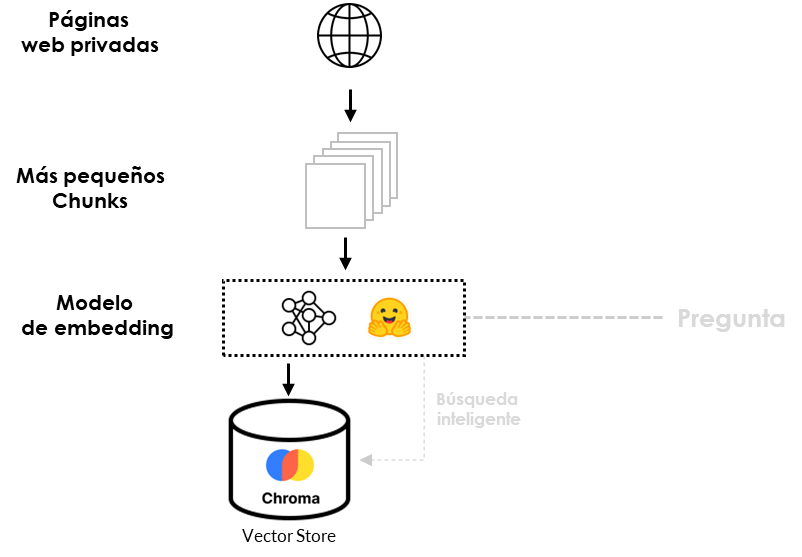

Para obtener una respuesta precisa a nuestra pregunta anterior, **`Que es wi-fi 7?`** tendremos que conectar nuestro LLM con información sobre wi-fi 7.

In [10]:
urls = [
    "https://www.redeszone.net/noticias/wifi/oficial-wifi-7-lanzamiento/",
    "https://www.netgear.com/es/home/discover/wifi7/"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)
# output: 2

2

Ahora tenemos dos documentos de gran tamaño repletos de datos, y eso podría superar la **ventana de contexto** de nuestro Mistral-7b LLM. Para mantener todo bajo control, vamos a dividirlos en **21 documentos más pequeños** o **chunks**, cada uno con un límite de **1024 tokens**. Además, hemos fijado el tamaño de **chunk overlap** en **64** para garantizar que haya cierta continuidad de contexto entre trozos consecutivos. Permanece atento al próximo paso en la ingesta de esta aventura de datos.

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)
# output: 21

27

#### Ingesta de datos

Una vez que tenemos nuestros trozos de datos manejables, el siguiente paso es incrustarlos e indexarlos en **Chromdb**, nuestro **vector store**. ¿Y lo mejor? Es muy fácil y se puede hacer con una sola línea de código.

In [12]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

Una vez indexados nuestros datos, en el script que aparece a continuación, ajustamos nuestra plantilla de consulta para que se adapte a nuestras necesidades y damos a nuestro modelo de RAG la personalidad de un experto en gestión de marketing.

Además, para combinar nuestro LLM con las capacidades de recuperación de la base de datos vectorial, utilizamos el componente crucial de encadenamiento **RetrievalQA** con **`k=2`**. Esta configuración garantiza que el recuperador produzca dos fragmentos relevantes, que el LLM utiliza para formular la respuesta cuando se presenta una pregunta.

In [13]:
template = """
[INST] <>
Actúe como un experto en marketing manager de wi-fi 7. Utilice la siguiente información para responder la pregunta al final..
<>

{context}

{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

#### Querying

**¡Estupendo**! Nuestro sistema GAR está listo para responder a tus preguntas. Así que vamos a sumergirnos en él y a hacerle algunas preguntas, incluida la que nos hemos saltado antes. ¡Allá vamos!

In [14]:
query = "Que es wi-fi 7?"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Que es wi-fi 7?</b>

<p>Wi-Fi 7 es el último estándar de Wi-Fi actualmente disponible. Es una continuación de Wi-Fi 6 y trae varias mejoras en cuanto a velocidad, cobertura y capacidad para conectar más dispositivos a la red. Está diseñado para proporcionar una experiencia de conexión rápida y confiable, incluso en entornos con muchos dispositivos conectados.</p>

In [15]:
query = "Porque se creo wi-fi 7"
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Porque se creo wi-fi 7</b>

<p>Wi-Fi 7 es el último estándar de Wi-Fi oficial hasta la fecha. Es una importante actualización sobre Wi-Fi 6, ofreciendo una mayor velocidad, mejor cobertura y capacidad para conectar más dispositivos a la red. El lanzamiento no ha sido sorprendente ni su especificación, ya que se han estado hablando de ello durante varios meses. Hay un artículo completamente explicativo de las novedades de Wi-Fi 7 que contiene todos los detalles relacionados con las mejoras de velocidad y capacidad para conectar más cosas a la red.</p>

Et voilá!. Tenemos grandes respuestas para ambas preguntas, incluida la que se nos pasó antes. Cabe señalar que podemos imprimir las **source documents** o **documentos de referencia** a partir de las cuales el LLM ha generado las respuestas. El escenario ahora es tuyo; considera la siguiente línea como el punto de partida para tu exploración.

In [16]:
result_["source_documents"]

[Document(page_content='Hasta ahora, el último estándar disponible de forma oficial era Wi-Fi 6. Trajo ya cambios importantes respecto al Wi-Fi 5, como es una mayor velocidad, mejora en la cobertura o capacidad para tener más aparatos conectados. Todo esto mejora ahora gracias al Wi-Fi 7, que poco a poco irá apareciendo en los dispositivos nuevos.\nEl Wi-Fi 7 ya es una realidad\nNo nos pilla por sorpresa este lanzamiento, como tampoco sus especificaciones, ya que llevamos meses hablando de ello. Ya publicamos un completo artículo explicando las novedades del Wi-Fi 7. Allí tenemos todos los detalles relacionados con las mejoras de velocidad y la capacidad para tener más cosas conectadas a la red.', metadata={'source': 'https://www.redeszone.net/noticias/wifi/oficial-wifi-7-lanzamiento/'}),
 Document(page_content='Hasta ahora, el último estándar disponible de forma oficial era Wi-Fi 6. Trajo ya cambios importantes respecto al Wi-Fi 5, como es una mayor velocidad, mejora en la cobertura o

#### Follow-Up Q/A

En el mundo real, el chat de seguimiento es útil, especialmente con los asistentes conversacionales de IA. Permite a los usuarios entablar conversaciones naturales con el modelo al mismo tiempo que conserva el historial de chat en el contexto del modelo. Esto significa que los usuarios pueden referirse implícitamente a algo de lo que han hablado en mensajes de chat anteriores o sacar a colación temas sobre los que han charlado en el pasado. Es como charlar amistosamente con un amigo de la inteligencia artificial que te recuerda. 🗨️💬

Para que esto suceda, primero hacemos algunos ajustes en la plantilla de avisos. A continuación, utilizamos **`ConversationBufferMemory`** para almacenar la conversación en memoria y recuperar los mensajes más tarde. Por último, empleamos el componente de encadenamiento **`ConversationalRetrievalChain`** para combinar nuestro LLM, Mistral-7b, con la base de datos vectorial y el historial de chat. Todo ello, para mejorar la experiencia de conversación del usuario.

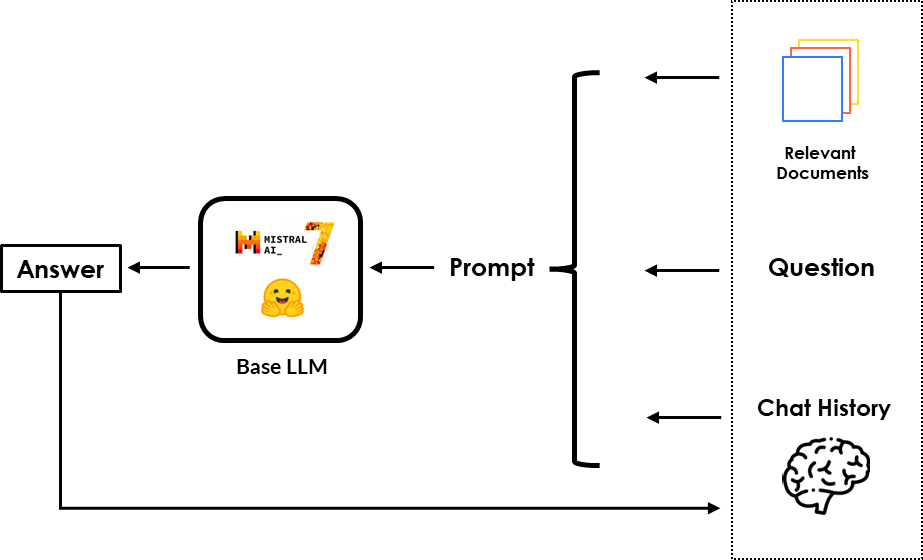

In [17]:
custom_template = """Eres un asistente de IA del gerente de marketing de wi-fi 7. Dada la
siguiente conversación y una pregunta de seguimiento, reformule la pregunta de seguimiento
para que sea una pregunta independiente. Al final de la pregunta independiente agregue esto
'Responda la pregunta en idioma español.' Si no sabe la respuesta, responda "Lo siento, no tengo suficiente información".
Historial de chat:
{chat_history}
Entrada de seguimiento: {question}
Pregunta independiente:
"""

CUSTOM_QUESTION_PROMPT = PromptTemplate.from_template(custom_template, language="es")

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    memory=memory,
    condense_question_prompt=CUSTOM_QUESTION_PROMPT,
)

In [18]:
query = "Quien eres?"
result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Quien eres?</b>

<p>I am Mistral 7B language model trained by Mistral AI.</p>

In [19]:
query = "Que es wi-fi 7?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Que es wi-fi 7?</b>

<p>WiFi 7 es una nueva generación de WiFi que ofrece mejoras significativas en velocidad y ancho de banda, junto con una serie de mejoras tecnológicas subyacentes diseñadas para hacer que su WiFi funcione de manera más inteligente y eficiente. Se espera que los primeros productos de WiFi 7 estén disponibles a mediados de 2023, y se espera que la adopción del mercado sea más amplia a finales de 2024 y más allá.</p>

In [20]:
query = "Por qué ha sido creado?"

result_ = qa_chain({"question": query})
result = result_["answer"].strip()

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<b>Por qué ha sido creado?</b>

<p>The objective of creating Wi-Fi 7 is to improve upon the previous standard, Wi-Fi 6, by bringing changes such as increased speed, improved coverage or capacity for more devices to be connected to the network.</p>

Si todavía tienes dudas sobre tu historial de chat, puedes ejecutar estos fragmentos de código para echarle un vistazo a tus preguntas en **HumanMessages** y a las respuestas del modelo en **AIMessages**. Esto te dará una visión clara de la conversación y te ayudará a resolver cualquier duda que puedas tener. ¡Es una forma práctica de hacer un seguimiento de la interacción! 🕵️‍♂️💬

In [21]:
memory.chat_memory.messages

[HumanMessage(content='Quien eres?'),
 AIMessage(content=' I am Mistral 7B language model trained by Mistral AI.'),
 HumanMessage(content='Que es wi-fi 7?'),
 AIMessage(content=' WiFi 7 es una nueva generación de WiFi que ofrece mejoras significativas en velocidad y ancho de banda, junto con una serie de mejoras tecnológicas subyacentes diseñadas para hacer que su WiFi funcione de manera más inteligente y eficiente. Se espera que los primeros productos de WiFi 7 estén disponibles a mediados de 2023, y se espera que la adopción del mercado sea más amplia a finales de 2024 y más allá.'),
 HumanMessage(content='Por qué ha sido creado?'),
 AIMessage(content=' The objective of creating Wi-Fi 7 is to improve upon the previous standard, Wi-Fi 6, by bringing changes such as increased speed, improved coverage or capacity for more devices to be connected to the network.')]

### **Gradio Chat UI**

**Gradio** es tu tren de alta velocidad para **mostrar** tu modelo de RAG en una interfaz web fácil de usar a la que cualquiera puede acceder desde cualquier lugar. Funciona así: hemos creado una función llamada **`querying()`**. Toma **`query`** como entrada principal, junto con un argumento falso llamado **`history`** para resolver un problema menor. Cuando se activa esta función, devuelve la respuesta generada por nuestro modelo superestrella, Mistral-7b. ¡Así de sencillo! 🚀

In [22]:
def querying(query, history):
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

  qa_chain = ConversationalRetrievalChain.from_llm(
      llm=llm,
      retriever=db.as_retriever(search_kwargs={"k": 2}),
      memory=memory,
      condense_question_prompt=CUSTOM_QUESTION_PROMPT,
  )

  result = qa_chain({"question": query})
  return result["answer"].strip()

In [23]:
iface = gr.ChatInterface(
    fn = querying,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="Que es wi-fi 7?", container=False, scale=7),
    title="Bonillo Software Bot",
    theme="soft",
    examples=["Por qué ha sido creado wi-fi 7?",
              "Que es wi-fi 7?"],

    cache_examples=True,
    retry_btn="Repetir",
    undo_btn="Deshacer",
    clear_btn="Borrar",
    submit_btn="Enviar"

    )

iface.launch(share=True)

Using cache from '/content/gradio_cached_examples/15' directory. If method or examples have changed since last caching, delete this folder to clear cache.

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://724cc5f6e40479fabb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### **Conclusión**

Las aplicaciones **RAG** están poniendo patas arriba el panorama de la IA, gracias a los saltos dados por los grandes modelos lingüísticos. Herramientas como LangChain, LlamaIndex y marcos similares están allanando el camino para el rápido desarrollo de aplicaciones que aprovechen todo el potencial de los LLM. Esto incluye **aumentar** los conocimientos de los LLM con datos privados como **PDF**, **URL**, **vídeos**, etc., datos con los que nunca se han encontrado durante su entrenamiento inicial.

De hecho, no hemos mencionado que también se puede crear una aplicación RAG utilizando datos de todo Internet, no sólo de unos pocos enlaces o páginas web... Para ello, primero hay que utilizar un **retriever** que obtenga dinámicamente las páginas web pertinentes de Internet, utilizando, por ejemplo, las **Google Search APIs** o cualquier otra alternativa. A continuación, puede utilizar un **re-ranker** para ordenar y clasificar el contenido de todas las páginas web recuperadas, proporcionando al LLM el contexto relevante necesario para generar la respuesta perfecta para una consulta determinada.

¿Y lo mejor? RAG también puede implementarse de forma segura en la nube. Existen opciones como **OpenAI On Your Data** dentro de **Azure**, **Amazon Bedrock** y toda una serie de servicios en **GCP**. ¡Es una revolución en IA con posibilidades ilimitadas! 🚀💻.

Estad atentos, ¡y hasta pronto! 📻👋😊

___